# ROMY - Barometric Models

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from src.baroseis import baroseis


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in la

AttributeError: _ARRAY_API not found

### Configurations

In [20]:
station = "ROMY" # "FUR" or "ROMY" or "DROMY"

# date = "20240312"
# date = "20240315"
# date = "20240321"
# date = "20240423"
date = "20240324"
# date = "20240829"

# Frequency range
fmin = 5e-4
fmax = 1e-2

save_figs = False

# select channel: A = tilt, J = rotation rate, H = acceleration
cha ="*A*"

# load config
config = baroseis.load_from_yaml(f"./config/config_FFBI_{station}_{date}_file.yaml")

path_to_figs = f"./figures/{date}/"

### Load Spatial Pressure Gradients

In [21]:
from functions.read_sds import read_sds

In [22]:
# gradient = obs.read(f"./data/pressure_gradient_{date}.mseed")
gradient = read_sds(f"./data/", "BW.PROMY.01.LDE", config['tbeg'], config['tend'])
gradient += read_sds(f"./data/", "BW.PROMY.01.LDN", config['tbeg'], config['tend'])


gradient = gradient.detrend("linear")
gradient = gradient.detrend("demean")
gradient = gradient.taper(0.05, "cosine")
gradient = gradient.filter("bandpass", freqmin=5e-4, freqmax=0.002, corners=4, zerophase=True)

gradient = gradient.trim(config['tbeg'], config['tend'])
gradient = gradient.detrend("demean")
gradient = gradient.taper(0.05, "cosine")
gradient

2 Trace(s) in Stream:
BW.PROMY.01.LDE | 2024-03-24T15:00:00.000000Z - 2024-03-24T17:00:00.000000Z | 1.0 Hz, 7201 samples
BW.PROMY.01.LDN | 2024-03-24T15:00:00.000000Z - 2024-03-24T17:00:00.000000Z | 1.0 Hz, 7201 samples

In [23]:
# Initialize baroseis object
bs = baroseis(conf=config)

# Load data specified in config
bs.load_data()

Creating new Hilbert transform data...
 -> No resampling required!

>Runtime: 0.0 minutes



In [24]:
bs.st

5 Trace(s) in Stream:
BW.FFBI..BDO   | 2024-03-24T14:00:00.005000Z - 2024-03-24T18:00:00.005000Z | 1.0 Hz, 14401 samples
BW.ROMY.40.BJE | 2024-03-24T13:59:59.997801Z - 2024-03-24T17:59:59.997801Z | 1.0 Hz, 14401 samples
BW.ROMY.40.BJN | 2024-03-24T13:59:59.989801Z - 2024-03-24T17:59:59.989801Z | 1.0 Hz, 14401 samples
BW.ROMY.40.BJZ | 2024-03-24T14:00:00.004199Z - 2024-03-24T18:00:00.004199Z | 1.0 Hz, 14401 samples
BW.FFBI..BDH   | 2024-03-24T14:00:00.005000Z - 2024-03-24T18:00:00.005000Z | 1.0 Hz, 14401 samples

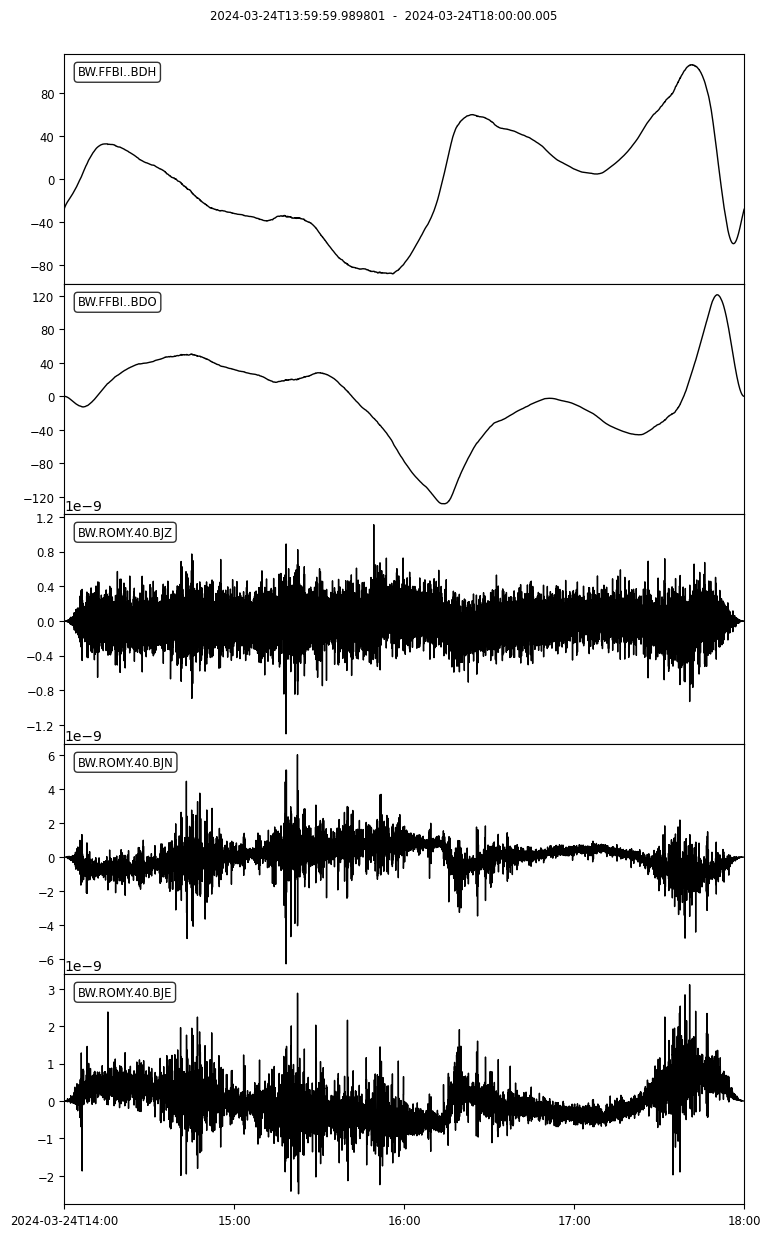

In [25]:
bs.st.plot(equal_scale=False);

Removing mean and trend...
Applying bandpass filter: 0.0005-0.01 Hz
 >Integrating ['JZ', 'JN', 'JE']


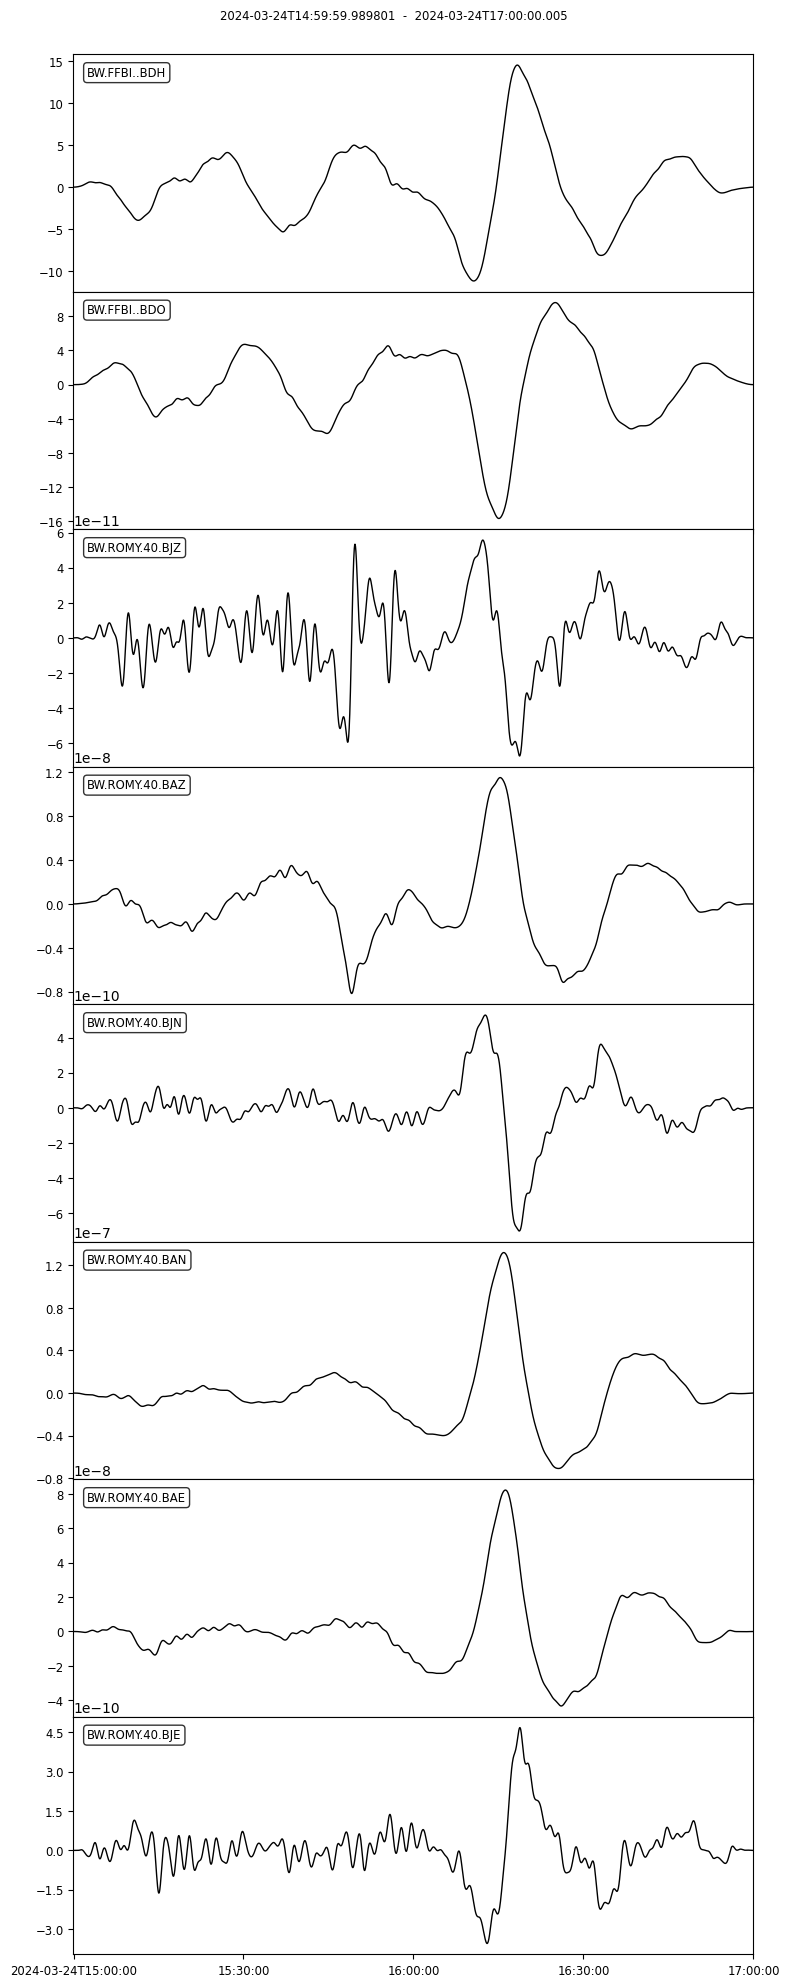

In [26]:
# band pass filer
bs.filter_data(fmin=fmin, fmax=fmax)

# detrend
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.1, "cosine")

if station == "ROMY":
    # integrate rotation to tilt
    bs.integrate_data(method="cumtrapz") # method = "cumtrapz" or "spline"

elif station == "FUR" or station == "DROMY":
    # convert acceleration to tilt
    for tr in bs.st:
        if tr.stats.channel[1] == "H":
            tr.stats.channel = tr.stats.channel[0] + "A" + tr.stats.channel[-1]
            if tr.stats.channel[-1] in ["N", "E"]:
                tr.data = -tr.data/9.81
    
# trim waveforms
bs.st = bs.st.trim(bs.config['tbeg'], bs.config['tend'])

# detrend waveforms
bs.st.detrend("demean")

# taper edges
bs.st.taper(0.05, "cosine")

# show new waveforms
bs.st.plot(equal_scale=False);


In [27]:
def model_tilt(seis_stream, pressure_data):
    """
    Simple model for predicting tilt/rotation from pressure data.
    
    Args:
        seis_stream: Stream with seismic data
        pressure_data: List of pressure arrays [P, H, DP, DH]
    
    Returns:
        Dictionary with predicted_data, coefficients, variance_reduction, residuals
    """
    
    # Get seismic data
    components = ['N', 'E', 'Z']
    seis_data = {}
    
    for comp in components:
        try:
            tr = seis_stream.select(component=comp).copy()[0]
            seis_data[comp] = tr.data
        except:
            continue
    
    if not seis_data:
        raise ValueError("No seismic data found")
    
    # Ensure all data has same length
    data_length = len(pressure_data[0])
    for comp in seis_data:
        if len(seis_data[comp]) != data_length:
            # Simple interpolation
            from scipy.interpolate import interp1d
            x_old = np.linspace(0, 1, len(seis_data[comp]))
            x_new = np.linspace(0, 1, data_length)
            f = interp1d(x_old, seis_data[comp], kind='linear', fill_value='extrapolate')
            seis_data[comp] = f(x_new)
    
    # Create design matrix
    A = np.column_stack(pressure_data)
    
    # Results
    results = {
        'predicted_data': {},
        'coefficients': {},
        'variance_reduction': {},
        'residuals': {}
    }
    
    # Process each component
    for comp, seis_comp_data in seis_data.items():
        # Least squares: A * x = b
        coefficients = np.linalg.lstsq(A, seis_comp_data, rcond=None)[0]
        predicted_data = A @ coefficients
        
        # Variance reduction
        original_var = np.var(seis_comp_data)
        residual_var = np.var(seis_comp_data - predicted_data)
        var_reduction = ((original_var - residual_var) / original_var) * 100
        
        # Store
        results['predicted_data'][comp] = predicted_data
        results['coefficients'][comp] = coefficients
        results['variance_reduction'][comp] = var_reduction
        results['residuals'][comp] = seis_comp_data - predicted_data
    
    return results

### Model Pressure

In [28]:
seis = bs.st.select(channel=cha).copy()
model_data = [
    bs.st.select(channel="*DO").copy()[0].data,
]

# Run model
model1 = model_tilt(seis, model_data)

# Access results
print("Variance reduction:")
for comp in model1['predicted_data']:
    print(f"{comp}: {model1['variance_reduction'][comp]:.1f}%")

# make stream with residuals
seis_model1_residuals = bs.st.select(channel=cha).copy()
for tr in seis_model1_residuals:
    ch = tr.stats.channel[2]
    tr.data = model1['residuals'][ch]


Variance reduction:
N: 81.7%
E: 69.1%
Z: 55.3%


### Model Gradient

In [29]:
seis = seis_model1_residuals.copy()
pressure_data = [
    # bs.st.select(channel="*DO").copy()[0].data,
    # bs.st.select(channel="*DH").copy()[0].data,
    gradient.select(channel="*DN").copy().differentiate()[0].data,
    gradient.select(channel="*DE").copy().differentiate()[0].data
]

# Run model
model2 = model_tilt(seis, pressure_data)

# Access results
print("Variance reduction:")
for comp in model2['predicted_data']:
    print(f"{comp}: {model2['variance_reduction'][comp]:.1f}%")

# make stream with residuals
seis_model2_residuals = bs.st.select(channel=cha).copy()
for tr in seis_model2_residuals:
    ch = tr.stats.channel[2]
    tr.data = model2['residuals'][ch]


Variance reduction:
N: 31.3%
E: 32.3%
Z: 1.8%


In [30]:
def plot_vr_comparison(model_list, figsize=(8, 5)):
    """
    Simple variance reduction comparison plot for a list of models.
    
    Args:
        model_list: List of dictionaries, each with 'name' and 'variance_reduction' keys
        figsize: Figure size tuple
    
    Example:
        models = [
            {'name': 'Basic', 'variance_reduction': {'N': 45, 'E': 38, 'Z': 52}},
            {'name': 'With Derivatives', 'variance_reduction': {'N': 67, 'E': 61, 'Z': 73}},
            {'name': 'Advanced', 'variance_reduction': {'N': 72, 'E': 69, 'Z': 79}}
        ]
        plot_vr_comparison(models)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Colors for different models
    colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    
    components = ['N', 'E', 'Z']
    x = np.arange(len(components))
    width = 0.8 / len(model_list)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i, model in enumerate(model_list):
        vr_values = [model['variance_reduction'].get(comp, 0) for comp in components]
        ax.bar(x + i * width, vr_values, width, 
               label=model['name'], color=colors[i % len(colors)], alpha=0.8)
        
    ax.set_ylabel('Variance Reduction (%)')
    ax.set_title('Variance Reduction Comparison')
    ax.set_xticks(x + width * (len(model_list) - 1) / 2)
    ax.set_xticklabels(f"{comp}-component" for comp in components)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    return fig

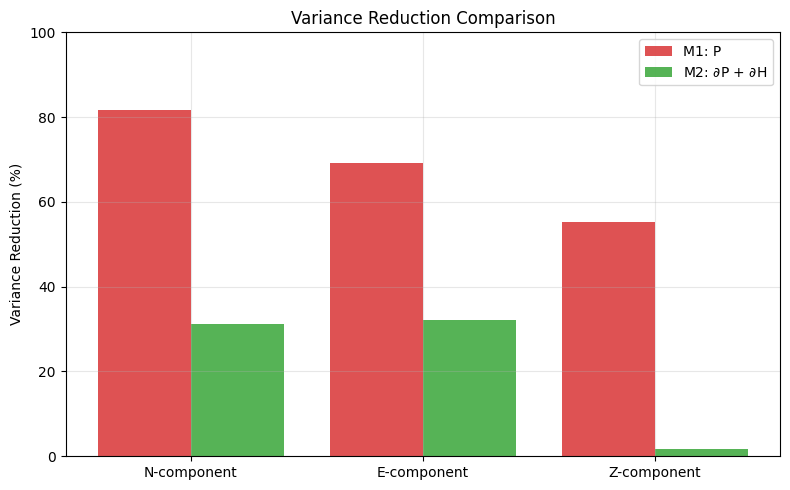

In [31]:
# Define your models
models = [
    {'name': r'M1: P', 'variance_reduction': model1['variance_reduction']},
    {'name': r'M2: $\partial$P + $\partial$H', 'variance_reduction': model2['variance_reduction']},
]

# Plot
fig = plot_vr_comparison(models)

if save_figs:
    fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_vr_comparison.png", dpi=150, bbox_inches="tight")

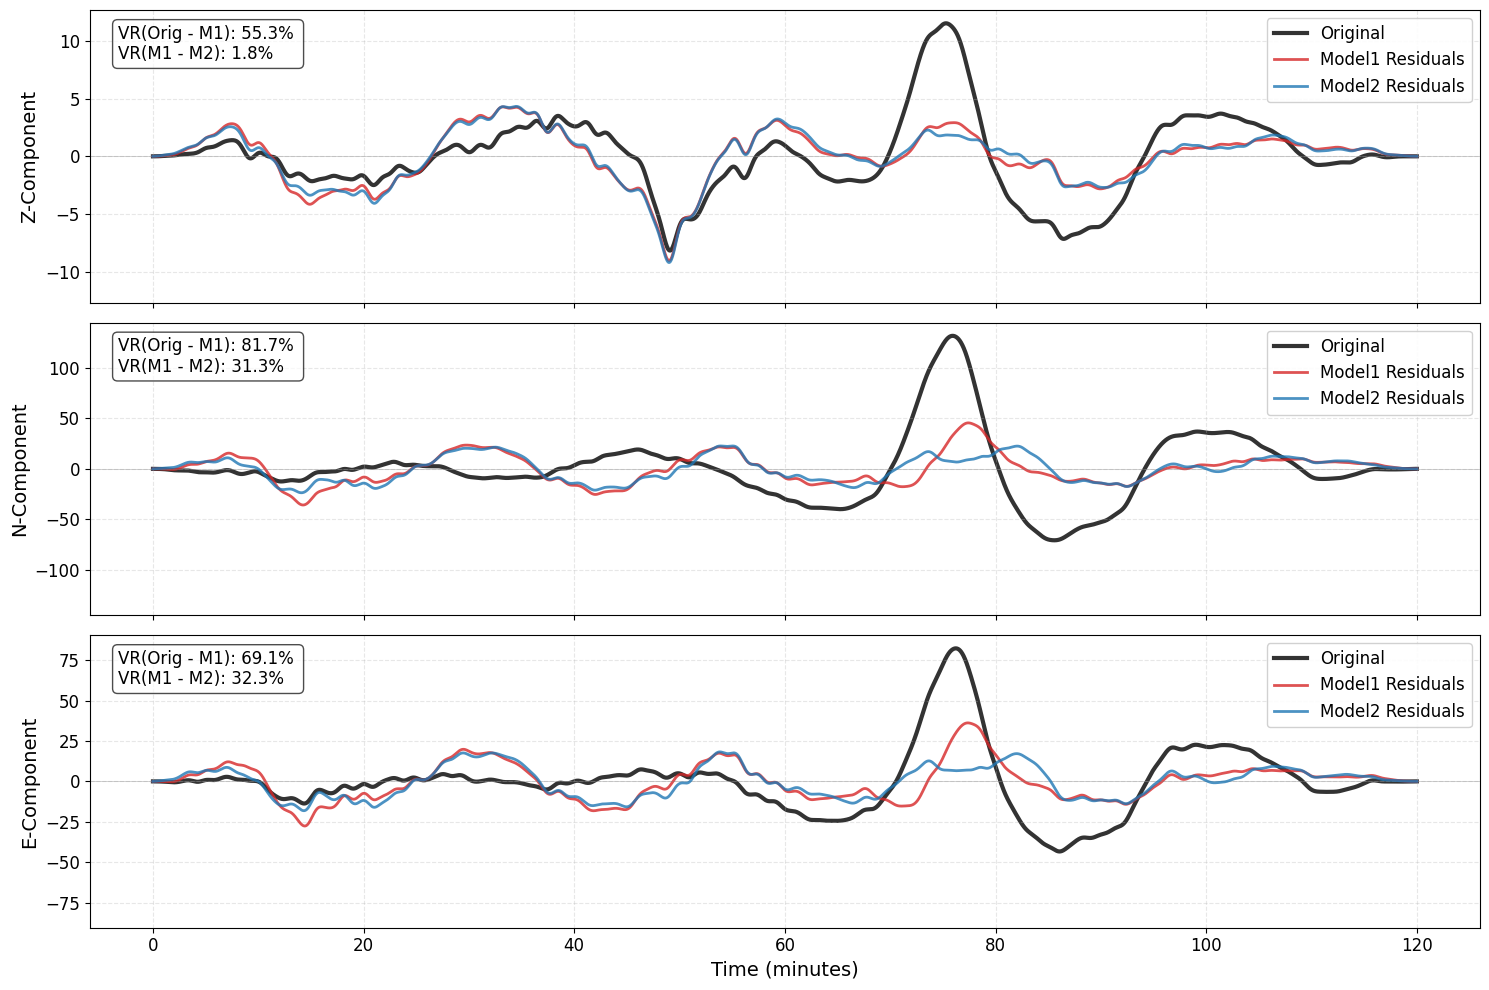

In [32]:
def plot_modelling_results(st1, st2, st3, components=['Z', 'N', 'E'], 
                          model1_vr=None, time_unit='hours', figsize=(15, 10)):
    """
    Plot original data and model residuals with variance reduction information.
    
    Args:
        st1: Original data stream
        st2: Model1 residuals stream
        st3: Model2 residuals stream
        components: List of components to plot
        model1_vr: Optional dict with Model1 variance reduction values
        time_unit: Time unit for x-axis
        figsize: Figure size tuple
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    yscale = 1e9 # to nrad

    # Time scaling
    tscale_dict = {"hours": 1/3600, "days": 1/86400, "minutes": 1/60, "seconds": 1}
    tscale = tscale_dict.get(time_unit, 1/3600)
    
    # Colors
    colors = {'Original': 'k', 'Model1 Residuals': 'tab:red', 'Model2 Residuals': 'tab:blue'}
    
    fig, axes = plt.subplots(len(components), 1, figsize=figsize, sharex=True)
    
    # Calculate variance reductions
    vr_orig_m1 = {}
    vr_m1_m2 = {}
    
    for comp in components:
        try:
            orig_data = st1.select(channel=f"*{comp}*")[0].data*yscale
            m1_residual = st2.select(channel=f"*{comp}*")[0].data*yscale
            m2_residual = st3.select(channel=f"*{comp}*")[0].data*yscale
            
            # VR between Original and Model1 (if not provided)
            if model1_vr is not None and comp in model1_vr:
                vr_orig_m1[comp] = model1_vr[comp]
            else:
                orig_var = np.var(orig_data)
                m1_var = np.var(m1_residual)
                vr_orig_m1[comp] = ((orig_var - m1_var) / orig_var) * 100 if orig_var > 0 else 0
            
            # VR between Model1 and Model2
            m1_var = np.var(m1_residual)
            m2_var = np.var(m2_residual)
            vr_m1_m2[comp] = ((m1_var - m2_var) / m1_var) * 100 if m1_var > 0 else 0
            
        except Exception as e:
            print(f"Error calculating VR for {comp}: {e}")
            vr_orig_m1[comp] = 0
            vr_m1_m2[comp] = 0
    
    # Plot each component
    for i, comp in enumerate(components):
        try:
            tr1 = st1.select(component=comp)[0]
            tr2 = st2.select(component=comp)[0]
            tr3 = st3.select(component=comp)[0]
            
            times = tr1.times() * tscale
            
            # Plot data
            axes[i].plot(times, tr1.data*yscale, label="Original", color=colors['Original'], 
                        linewidth=3, alpha=0.8, zorder=1)
            axes[i].plot(times, tr2.data*yscale, label="Model1 Residuals", color=colors['Model1 Residuals'], 
                        linewidth=2, alpha=0.8, zorder=2)
            axes[i].plot(times, tr3.data*yscale, label="Model2 Residuals", color=colors['Model2 Residuals'], 
                        linewidth=2, alpha=0.8, zorder=3)
            
            # Add variance reduction text
            text_str = f"VR(Orig - M1): {vr_orig_m1[comp]:.1f}% \nVR(M1 - M2): {vr_m1_m2[comp]:.1f}%"
            axes[i].text(0.02, 0.95, text_str, transform=axes[i].transAxes,
                        fontsize=12, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))
            
            # Formatting
            axes[i].set_ylabel(f"{comp}-Component", fontsize=14)
            axes[i].legend(loc='upper right', fontsize=12, framealpha=0.9)
            axes[i].grid(True, alpha=0.3, linestyle='--')
            axes[i].axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            
            # Set symmetric y-limits
            all_data = np.concatenate([tr1.data*yscale, tr2.data*yscale, tr3.data*yscale])
            y_max = np.max(np.abs(all_data)) * 1.1
            axes[i].set_ylim(-y_max, y_max)
            axes[i].tick_params(axis='both', which='major', labelsize=12)

        except Exception as e:
            print(f"Error plotting {comp}: {e}")
            axes[i].text(0.5, 0.5, f'Error loading {comp}', 
                        ha='center', va='center', transform=axes[i].transAxes)

    # Set x-axis label
    axes[-1].set_xlabel(f"Time ({time_unit})", fontsize=14)
    
    # Overall title
    # fig.suptitle("Modeling Results Comparison", fontsize=14, y=0.995)
    
    plt.tight_layout()
    return fig

fig = plot_modelling_results(
    bs.st.select(channel=cha), 
    seis_model1_residuals, 
    seis_model2_residuals,
    model1_vr=model1['variance_reduction'],
    time_unit='minutes'
)

fig.savefig(f"{path_to_figs}{date}_{station}_{cha}_model_workflow.png", dpi=150, bbox_inches="tight")